## DNN feature viz for ResNet18 on CIFAR10: fp32 vs. int8 model

In [2]:
from copy import deepcopy

import numpy as np
import torch
import nncf
import torch.nn.functional as F
from nncf import create_compressed_model, NNCFConfig, register_default_init_args

from torchvision import models, datasets, transforms

seed = 42

torch.manual_seed(seed)

### CIFAR10 dataset utils

In [3]:
def get_CIFAR10(root="./"):
    input_size = 32
    num_classes = 10
    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

    train_transform = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]
    )
    train_dataset = datasets.CIFAR10(
        root + "data/CIFAR10", train=True, transform=train_transform, download=True
    )

    test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            normalize,
        ]
    )
    test_dataset = datasets.CIFAR10(
        root + "data/CIFAR10", train=False, transform=test_transform, download=True
    )

    return input_size, num_classes, train_dataset, test_dataset

### ResNet18 model from torchvision modified for CIFAR10

In [4]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = models.resnet18(pretrained=False, num_classes=10)

        self.resnet.conv1 = torch.nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.resnet.maxpool = torch.nn.Identity()

    def forward(self, x):
        x = self.resnet(x)
        x = F.log_softmax(x, dim=1)

        return x

### Validation dataset accuracy check

In [5]:
def test(model, test_loader):
    model.eval()

    loss = 0
    correct = 0

    for data, target in test_loader:
        with torch.no_grad():
            data = data.cuda()
            target = target.cuda()

            prediction = model(data)
            loss += F.nll_loss(prediction, target, reduction="sum")

            prediction = prediction.max(1)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    return loss, percentage_correct

In [6]:
input_size, num_classes, train_dataset, test_dataset = get_CIFAR10()
kwargs = {"num_workers": 16, "pin_memory": True}
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=True, **kwargs
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=5000, shuffle=False, **kwargs
)

Files already downloaded and verified
Files already downloaded and verified


### NNCF config for model compression

In [7]:
nncf_config_dict = {
        "compression": {
            "algorithm": "quantization",
            "initializer": {
                "range": {
                    "num_init_steps": 5
                }
            }
        }
    }
nncf_config = NNCFConfig(nncf_config_dict)
nncf_config = register_default_init_args(nncf_config, None, train_loader)

In [10]:
model = Model()
model = model.cuda()
compression_ctrl, compressed_model = create_compressed_model(deepcopy(model), nncf_config)
    
CKPT_PATH = './resnet18_cifar10.pth'
model.load_state_dict(torch.load(CKPT_PATH))

INT8_CKPT_PATH = './resnet18_cifar10_int8.pth'
compressed_model.load_state_dict(torch.load(INT8_CKPT_PATH))

INFO:nncf:Wrapping module Model/ResNet[resnet]/Conv2d[conv1] by Model/ResNet[resnet]/NNCFConv2d[conv1]
INFO:nncf:Wrapping module Model/ResNet[resnet]/Sequential[layer1]/BasicBlock[0]/Conv2d[conv1] by Model/ResNet[resnet]/Sequential[layer1]/BasicBlock[0]/NNCFConv2d[conv1]
INFO:nncf:Wrapping module Model/ResNet[resnet]/Sequential[layer1]/BasicBlock[0]/Conv2d[conv2] by Model/ResNet[resnet]/Sequential[layer1]/BasicBlock[0]/NNCFConv2d[conv2]
INFO:nncf:Wrapping module Model/ResNet[resnet]/Sequential[layer1]/BasicBlock[1]/Conv2d[conv1] by Model/ResNet[resnet]/Sequential[layer1]/BasicBlock[1]/NNCFConv2d[conv1]
INFO:nncf:Wrapping module Model/ResNet[resnet]/Sequential[layer1]/BasicBlock[1]/Conv2d[conv2] by Model/ResNet[resnet]/Sequential[layer1]/BasicBlock[1]/NNCFConv2d[conv2]
INFO:nncf:Wrapping module Model/ResNet[resnet]/Sequential[layer2]/BasicBlock[0]/Conv2d[conv1] by Model/ResNet[resnet]/Sequential[layer2]/BasicBlock[0]/NNCFConv2d[conv1]
INFO:nncf:Wrapping module Model/ResNet[resnet]/Seque

INFO:nncf:Adding unsigned Activation Quantize in scope: Model/ResNet[resnet]/Sequential[layer3]/BasicBlock[0]/ReLU[relu]/RELU_1
INFO:nncf:Adding unsigned Activation Quantize in scope: Model/ResNet[resnet]/Sequential[layer4]/BasicBlock[0]/ReLU[relu]/RELU_0
INFO:nncf:Adding unsigned Activation Quantize in scope: Model/ResNet[resnet]/Sequential[layer1]/BasicBlock[1]/BatchNorm2d[bn2]/batch_norm_0
INFO:nncf:Adding unsigned Activation Quantize in scope: Model/ResNet[resnet]/Sequential[layer2]/BasicBlock[0]/ReLU[relu]/RELU_1
INFO:nncf:Adding unsigned Activation Quantize in scope: Model/ResNet[resnet]/Sequential[layer1]/BasicBlock[0]/ReLU[relu]/RELU_0
INFO:nncf:Adding unsigned Activation Quantize in scope: Model/ResNet[resnet]/Sequential[layer1]/BasicBlock[0]/BatchNorm2d[bn2]/batch_norm_0
INFO:nncf:Adding unsigned Activation Quantize in scope: Model/ResNet[resnet]/Sequential[layer4]/BasicBlock[1]/ReLU[relu]/RELU_1
INFO:nncf:Adding unsigned Activation Quantize in scope: Model/ResNet[resnet]/Seq

Range parameters initialization: 100%|██████████ |5/5 [00:00<00:00]

INFO:nncf:Set sign: True and scale: [2.7537, ] for NNCFNetwork/Model[nncf_module]/ResNet[resnet]/NNCFConv2d[conv1]/ModuleDict[pre_ops]/UpdateInputs[1]/SymmetricQuantizer[op]
INFO:nncf:Set sign: True and scale: [0.1924, ] for NNCFNetwork/Model[nncf_module]/ResNet[resnet]/NNCFConv2d[conv1]/ModuleDict[pre_ops]/UpdateWeight[0]/SymmetricQuantizer[op]
INFO:nncf:Set sign: True and scale: [0.1000, ] for NNCFNetwork/Model[nncf_module]/ResNet[resnet]/NNCFLinear[fc]/ModuleDict[pre_ops]/UpdateWeight[0]/SymmetricQuantizer[op]
INFO:nncf:Set sign: True and scale: [0.2543, ] for NNCFNetwork/Model[nncf_module]/ResNet[resnet]/Sequential[layer1]/BasicBlock[0]/NNCFConv2d[conv1]/ModuleDict[pre_ops]/UpdateWeight[0]/SymmetricQuantizer[op]
INFO:nncf:Set sign: True and scale: [0.2425, ] for NNCFNetwork/Model[nncf_module]/ResNet[resnet]/Sequential[layer1]/BasicBlock[0]/NNCFConv2d[conv2]/ModuleDict[pre_ops]/UpdateWeight[0]/SymmetricQuantizer[op]
INFO:nncf:Set sign: True and scale: [0.2339, ] for NNCFNetwork/Mode

INFO:nncf:Set sign: True and scale: [11.1217, ] for NNCFNetwork/ModuleDict[activation_quantizers]/SymmetricQuantizer[Model/ResNet[resnet]/Sequential[layer3]/BasicBlock[1]/BatchNorm2d[bn2]/batch_norm_0]
INFO:nncf:Set sign: False and scale: [9.4826, ] for NNCFNetwork/ModuleDict[activation_quantizers]/SymmetricQuantizer[Model/ResNet[resnet]/Sequential[layer3]/BasicBlock[1]/ReLU[relu]/RELU_0]


INFO:nncf:Set sign: False and scale: [17.1023, ] for NNCFNetwork/ModuleDict[activation_quantizers]/SymmetricQuantizer[Model/ResNet[resnet]/Sequential[layer3]/BasicBlock[1]/ReLU[relu]/RELU_1]
INFO:nncf:Set sign: True and scale: [10.2266, ] for NNCFNetwork/ModuleDict[activation_quantizers]/SymmetricQuantizer[Model/ResNet[resnet]/Sequential[layer4]/BasicBlock[0]/BatchNorm2d[bn2]/batch_norm_0]
INFO:nncf:Set sign: False and scale: [9.8169, ] for NNCFNetwork/ModuleDict[activation_quantizers]/SymmetricQuantizer[Model/ResNet[resnet]/Sequential[layer4]/BasicBlock[0]/ReLU[relu]/RELU_0]
INFO:nncf:Set sign: False and scale: [14.8186, ] for NNCFNetwork/ModuleDict[activation_quantizers]/SymmetricQuantizer[Model/ResNet[resnet]/Sequential[layer4]/BasicBlock[0]/ReLU[relu]/RELU_1]
INFO:nncf:Set sign: True and scale: [10.5592, ] for NNCFNetwork/ModuleDict[activation_quantizers]/SymmetricQuantizer[Model/ResNet[resnet]/Sequential[layer4]/BasicBlock[0]/Sequential[downsample]/BatchNorm2d[1]/batch_norm_0]
INF

<All keys matched successfully>

In [11]:
test(model, test_loader)

Test set: Average loss: 0.2788, Accuracy: 9220/10000 (92.20%)


(tensor(0.2788, device='cuda:0'), 92.2)

In [12]:
test(compressed_model, test_loader)

Test set: Average loss: 0.2878, Accuracy: 9215/10000 (92.15%)


(tensor(0.2878, device='cuda:0'), 92.15)

### Let's look at model structure

In [11]:
model

Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2)

### Import GradientAscent from flashtorch for activation maximization

Monkey-patching its optimize method to allow NNCFConv2d layers besides standard Conv2d

In [13]:
from flashtorch.activmax import GradientAscent
from flashtorch.utils import apply_transforms


def optimize(self, layer, filter_idx, input_=None, num_iter=30):

    # Validate filter index

    num_total_filters = layer.out_channels
    self._validate_filter_idx(num_total_filters, filter_idx)

    # Initialize input (as noise) if not provided

    if input_ is None:
        input_ = np.uint8(np.random.uniform(
            150, 180, (self._img_size, self._img_size, 3)))
        input_ = apply_transforms(input_, size=self._img_size)

    if torch.cuda.is_available() and self.use_gpu:
        self.model = self.model.to('cuda')
        input_ = input_.to('cuda')

    # Remove previous hooks if any

    while len(self.handlers) > 0:
        self.handlers.pop().remove()

    # Register hooks to record activation and gradients

    self.handlers.append(self._register_forward_hooks(layer, filter_idx))
    self.handlers.append(self._register_backward_hooks())

    # Inisialize gradients

    self.gradients = torch.zeros(input_.shape)

    # Optimize

    return self._ascent(input_, num_iter)


GradientAscent.optimize = optimize

### Visualize inputs that maximize activations in particular filters of compressed and uncompressed models

In [14]:
g_ascent = GradientAscent(model.resnet, img_size=32, use_gpu=True)

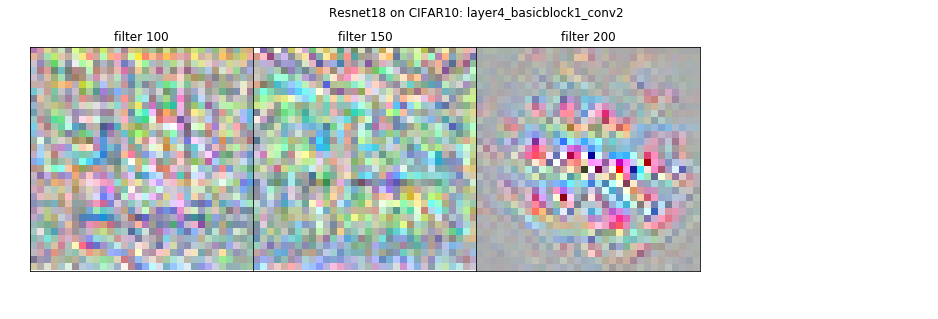

In [15]:
g_ascent.visualize(model.resnet.layer4[1].conv2, 
                   filter_idxs=[100, 150, 200], 
                   title='Resnet18 on CIFAR10: layer4_basicblock1_conv2')

In [16]:
g_ascent = GradientAscent(compressed_model.resnet, img_size=32, use_gpu=True)

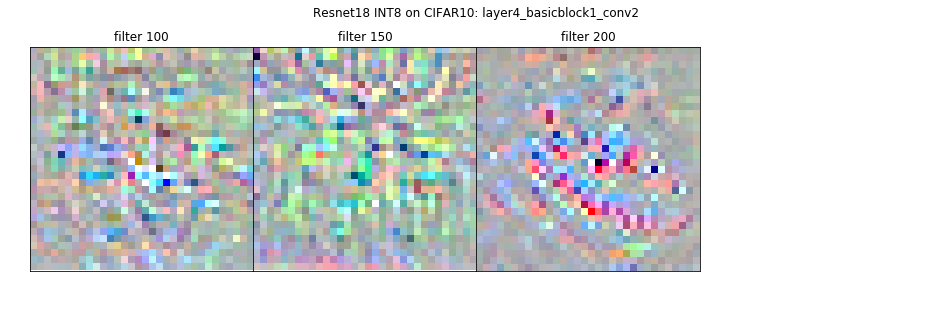

In [17]:
g_ascent.visualize(compressed_model.resnet.layer4[1].conv2, 
                   filter_idxs=[100, 150, 200], 
                   title='Resnet18 INT8 on CIFAR10: layer4_basicblock1_conv2')